# INFO284 Asignment 2
sas020

The network is defined with a learningrate (lr) of 0.001, 30 epochs and a batch size of 100. 

Through testing I found that increasing the lr would result in the network missing the bottom of the learning-slope, and decreasing the lr resulted in the network not learning fast enough. The model was tested with other lrs souch as 0.0005, 0.003.

With the current layering of the model I have found that around 30 epochs are needed for it to close in on it's best possible accuracy. The model was also tested with 40 epochs, this resulted in a testing accuracy of 91.7, but the delta between training and testing sets also increased. The training accuracy on the last epoch was measured at 96.1.

The batch size of 100 is the highest I was able to use, before the model would start to overfit, this could be spotted in the acc_history graph, where the accuracy would drastically drop at the start of each epoch. In some instances the accuracy would even drop from ~90% to ~40%. Through my testing the highest possible batch size, where the model did not overfit, yielded the best testing accuracy.

There is still some overfitting in the model, the delta between the training and test sets is ~3%.

I played around with different layering of the model, and found this to be the optimal. Removing the dropout results in the model overfitting on the training data, and other channel-selections, either more or less, would result in a lower testing accuracy, but keeping the slight overfitting as is now.
The same was the situation for the fully connected layer, where more layers would decrease the testing accuracy, while keeping or increasing the slight overfitting.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from torch.nn import Linear, Module, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:101: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 0 | Loss: 0.5642 | Train Accuracy: 79.583
Epoch: 1 | Loss: 0.3636 | Train Accuracy: 86.923
Epoch: 2 | Loss: 0.3133 | Train Accuracy: 88.718
Epoch: 3 | Loss: 0.2871 | Train Accuracy: 89.650
Epoch: 4 | Loss: 0.2669 | Train Accuracy: 90.325
Epoch: 5 | Loss: 0.2499 | Train Accuracy: 90.985
Epoch: 6 | Loss: 0.2375 | Train Accuracy: 91.452
Epoch: 7 | Loss: 0.2299 | Train Accuracy: 91.607
Epoch: 8 | Loss: 0.2168 | Train Accuracy: 92.262
Epoch: 9 | Loss: 0.2081 | Train Accuracy: 92.403
Epoch: 10 | Loss: 0.2016 | Train Accuracy: 92.660
Epoch: 11 | Loss: 0.1928 | Train Accuracy: 92.995
Epoch: 12 | Loss: 0.1894 | Train Accuracy: 93.128
Epoch: 13 | Loss: 0.1833 | Train Accuracy: 93.270
Epoch: 14 | Loss: 0.1793 | Train Accuracy: 93.372
Epoch: 15 | Loss: 0.1726 | Train Accuracy: 93.678
Epoch: 16 | Loss: 0.1677 | Train Accuracy: 93.815
Epoch: 17 | Loss: 0.1625 | Train Accuracy: 94.007
Epoch: 18 | Loss: 0.1601 | Train Accuracy: 94.112
Epoch: 19 | Loss: 0.1551 | Train Accuracy: 94.307
Epoch: 20 

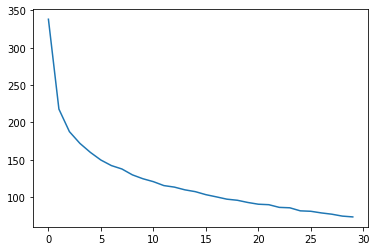

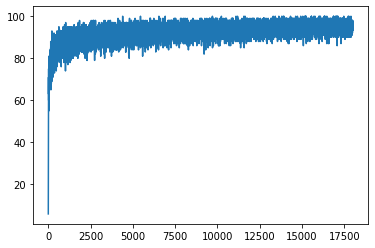

[[854   0  24  17   2   1  97   0   5   0]
 [  2 983   1  10   1   0   2   0   1   0]
 [  8   1 914   6  31   0  40   0   0   0]
 [  6   1  11 936  25   0  21   0   0   0]
 [  1   0  26  27 885   0  60   0   1   0]
 [  0   0   0   0   0 984   0  12   0   4]
 [ 90   0  56  25  56   0 768   0   5   0]
 [  0   0   0   0   0   8   0 981   0  11]
 [  1   0   5   3   2   1   2   1 985   0]
 [  0   0   0   0   0   8   0  57   0 935]]
Save model? y | n y


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


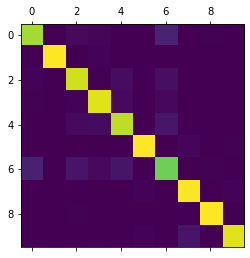

In [2]:
class CNN(Module):
	'''Convolutional Neural Network model.'''
	def __init__(self, lr, epochs, batch_size, num_classes = 10):
		super(CNN, self).__init__()

		self.lr = lr
		self.epochs = epochs
		self.batch_size = batch_size
		self.num_classes = num_classes
		self.loss_history = []
		self.acc_history = []
		self.predictions = []
		self.target = []
		self.class_labels = [
			'T-shirt/top',
			'Trouser',
			'Pullover',
			'Dress',
			'Coat',
			'Sandal',
			'Shirt',
			'Sneaker',
			'Bag',
			'Ankle boot',
		]

		self.device = T.device("cuda:0" if T.cuda.is_available() else "cpu")

		self.conv_layers = Sequential(	
					
			Conv2d(1, 64, 3),
			Dropout(0.5),
			BatchNorm2d(64),
			ReLU(),

			Conv2d(64, 256, 3),
			Dropout(0.5),
			BatchNorm2d(256),
			ReLU(),
			
			MaxPool2d(2),

			Conv2d(256, 256, 3),
			Dropout(0.5),
			BatchNorm2d(256),
			ReLU(),

			Conv2d(256, 256, 3),
			Dropout(0.5),
			BatchNorm2d(256),
			ReLU(),
			
			MaxPool2d(2),
		)

		# Calculate input-dimentions for fully connected layer
		input_dims = self.calc_input_dims()
		self.fc = Sequential(
			Linear(input_dims, self.num_classes),
		)

		self.optimizer = T.optim.Adam(self.parameters(), lr=self.lr)
		self.criterion = CrossEntropyLoss()

		self.to(self.device)
		self.get_data()

	def calc_input_dims(self):
		'''Calculate input-dimentions for fully connected layer'''
		batch_data = T.zeros((1, 1, 28, 28))
		return int(np.prod(self.conv_layers(batch_data).size()))

	def get_data(self):
		'''Download and load training and test data'''
		## Transformations to tensor
		transform = transforms.Compose([transforms.ToTensor()])

		## Download and load training dataset
		self.trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
		self.trainloader = T.utils.data.DataLoader(self.trainset, batch_size=self.batch_size,shuffle=True, num_workers=16)

		## Download and load testing dataset
		self.testset = torchvision.datasets.FashionMNIST(root='./data', train=False,download=True, transform=transform)
		self.testloader = T.utils.data.DataLoader(self.testset, batch_size=self.batch_size, shuffle=False, num_workers=16)

	def forward(self, batch_data):
		'''Forward propagation step'''
		batch_data = T.tensor(batch_data).to(self.device)

		batch_data = self.conv_layers(batch_data)
		batch_data = batch_data.flatten(start_dim = 1)

		classes = self.fc(batch_data)
		return classes

	def get_accuracy(self, logit, target):
		''' Obtain accuracy for training round '''
		corrects = (logit.view(target.size()).data == target.data).sum()
		accuracy = 100.0 * corrects / self.batch_size
		return accuracy.item()


	def _train(self):
		'''Train the model'''
		self.train()
		for i in range(self.epochs):
			train_loss = 0
			train_acc = []
			for j, (images, labels) in enumerate(self.trainloader):
				self.optimizer.zero_grad()

				labels = labels.to(self.device)

				# Forward + backprop + loss
				logits = self.forward(images)
				loss = self.criterion(logits, labels)
				logits = F.softmax(logits, dim=1).argmax(dim=1)

				prediction = self.get_accuracy(logits, labels)

				train_loss += loss.detach().item()
				train_acc.append(prediction)
				self.acc_history.append(prediction)

				loss.backward()
				self.optimizer.step()

			self.loss_history.append(train_loss)
			print(f'Epoch: {i} | Loss: {train_loss / j:.4f} | Train Accuracy: {np.mean(train_acc):.3f}')

	def test(self):
		'''Test the model'''
		test_loss = 0
		test_acc = []
		for i, (images, labels) in enumerate(self.testloader):
			labels = labels.to(self.device)

			# Forward + backprop + loss
			logits = self.forward(images)
			loss = self.criterion(logits, labels)
			logits = F.softmax(logits, dim=1).argmax(dim=1)
			self.predictions.extend(logits)
			self.target.extend(labels)

			prediction = self.get_accuracy(logits, labels)

			test_loss += loss.detach().item()
			test_acc.append(prediction)

		print(f'Loss: {test_loss / i:.4f} | Accuracy: {np.mean(test_acc):.3f}')

	def create_report(self):
		predictions = [t.cpu().numpy() for t in self.predictions]
		target = [t.cpu().numpy() for t in self.target]

		# Print classification report
		classification_matrix = classification_report(target, predictions, target_names=self.class_labels)
		print('Classification Report: \n', classification_matrix)

		# Plot testing loss and accuracy gradient
		plt.plot(net.loss_history)
		plt.show()
		plt.plot(net.acc_history)
		plt.show()

		# Create confusion matrix
		conf_matr = confusion_matrix(target, predictions)
		print(conf_matr)
		plt.matshow(conf_matr)

In [ ]:
# Create model, train and test
net = CNN(lr=0.001, epochs=30, batch_size=100)
net._train()
net.test()
net.create_report()

In [ ]:
# Save the model
T.save(net, './fashionMNIST_classifier.pt')

In [ ]:
# Load pre-trained model
net = T.load('./fashionMNIST_classifier.pt')
net.eval()
net.test()